# Introduction

在这节课中，我们将研究数据清理和探索性数据分析的过程。通常情况下，为了进行一些分析或回答一些问题，你会获得甚至得到一组数据。使用该数据的第一步是确保其格式正确(已清除)，并了解其属性和限制。在研究数据时，通常会确定在数据准备好进行分析之前可能需要的额外转换。

In this notebook we obtain crime data from public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data. 

In [1]:
import numpy as np
import pandas as pd

# Getting the Data

To begin this analysis we want to get data about crimes.  Remarkably, the city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining the:

1. Call Data
1. Stop Data

Fortunately, this data is also relatively well document with detailed descriptions of what it contains.  Here are summaries of the fields in the data:

**Calls Data**
<img src="calls_desc.png" width=800px />

**Stop Data**
<img src="stops_desc.png" width=800px />

## Load Data Path

### `./路径`
**<font color = red > 用相对路径就可以**

In [2]:
calls_file = "./data/calls_for_service.csv"

In [3]:
stops_file = "./data/stops.json"

---
How big is the data?

---
我通常喜欢通过粗略估计数据的大小来开始我的分析。这将有助于告知我使用的工具以及如何查看数据。如果它相对较小，我可能会使用文本编辑器或电子表格查看数据。如果它更大，我可能会跳转到更程序化的探索，甚至使用分布式计算工具。

不过，这里我们将使用python工具来探测该文件。

### <font color = red >`os.path.getsize`

In [4]:
import os # 写在这儿了~
print(calls_file, "is",  os.path.getsize(calls_file) / 1e6, "MB")
print(stops_file, "is", os.path.getsize(stops_file) / 1e6, "MB")

./data/calls_for_service.csv is 0.941358 MB
./data/stops.json is 17.134125 MB


All the files are relatively small and we could comfortable examine them in a text editors.  (Personally, I like *sublime*). 

In listing the files I noticed that the names suggest that they are all text file formats:
* **CSV**: 逗号分隔值是一种非常标准的表格格式。
* **JSON**: JavaScript对象表示法是一种非常标准的半结构化文件格式，用于存储嵌套数据。

We will dive into the formats in a moment.  However because these are text data I might also want to investigate the number of lines which often correspond to records.

### `with A as B`简写方法
<font color = red >相当于R里的`attach-detach`

In [5]:
with open(calls_file, "r") as f:
    print(calls_file, "is", sum(1 for l in f), "lines.") # 有换行就考虑

./data/calls_for_service.csv is 15452 lines.


***
Can we trust extensions?
***
我们已经注意到文件以csv和json结尾，这表明它们分别是用逗号分隔的和javascript对象文件。然而，我们不能总是依赖命名，因为这只是一种约定。例如，这里我们在下载时根据URL中的一些提示选择了文件的名称。

**通常文件的扩展名不正确或者根本没有扩展名。**

让我们假设这些是文本文件(不包含二进制编码的数据)，因此我们可以打印“几行”以更好地理解该文件。

In [6]:
print(calls_file, "======================")
with open(calls_file, "r") as f: # 相当于R里的attach（xxx）
    for i in range(20):
        print(i, "\t", repr(f.readline())) # readline 只读一行

./data/calls_for_service.csv ======================
0 	 'CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State\n'
1 	 '19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,1,09/10/2020 07:00:11 AM,"SHATTUCK AVE\n'
2 	 'Berkeley, CA",SHATTUCK AVE,Berkeley,CA\n'
3 	 '19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,0,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\n'
4 	 'Berkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA\n'
5 	 '19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,3,09/10/2020 07:00:10 AM,"2200 MILVIA ST\n'
6 	 'Berkeley, CA\n'
7 	 '(37.868574, -122.270415)",2200 MILVIA ST,Berkeley,CA\n'
8 	 '19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,0,09/10/2020 07:00:11 AM,"VIRGINIA ST\n'
9 	 'Berkeley, CA",VIRGINIA ST,Berkeley,CA\n'
10 	 '19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,6,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\n'
11 	 'Berkeley, CA",U

In [7]:
print(stops_file, "======================")
with open(stops_file, "r") as f:
    for i in range(20):
        print(i, "\t", repr(f.readline()))

./data/stops.json ======================
0 	 '{\n'
1 	 '  "meta" : {\n'
2 	 '    "view" : {\n'
3 	 '      "id" : "4tbf-3yt8",\n'
4 	 '      "name" : "Berkeley PD - Stop Data (NEW)",\n'
5 	 '      "attribution" : "City of Berkeley Police Department",\n'
6 	 '      "averageRating" : 0,\n'
7 	 '      "category" : "Public Safety",\n'
8 	 '      "createdAt" : 1588602591,\n'
9 	 '      "description" : "This data was extracted from the Department鈥檚 Public Safety Server and covers data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014). Under that Order, officers were required to provide certain data after making any detention (vehicle, bicycle, pedestrian, suspicious auto).  This dataset provides information about detentions, including the race, sex, age range, of the person detained; the reason for the stop; the type of enforcement taken (if any), and whether or not a search was conducted.  Also provi

注意，我使用了`repr`函数返回带有特殊字符的原始字符串。这对推断文件格式很有帮助。

*** 
What are some observations about `Calls` data?
***
1. It appears to be in comma separated value (CSV) format.
1. First line contains the column headings.
1. There are lots of **new-line** `\n` characters:
    * at the ends of lines (delimiting records?)
    * *within records* as part of addresses.
1. There are **"quoted"** strings in the `Block_Location` column:
```
"SHATTUCK AVE\n'
2 	 'Berkeley, CA"
```
these are going to be difficult.  What are the implications on our earlier line count calculations?

### JSON文件

这似乎是一个相当标准的JSON文件。我们注意到，该文件在一个名为`meta`(大概是元数据的缩写)的字段中似乎包含了对自身的描述。让我们快速讨论一下JSON文件格式。


[JSON (JavaScript Object Notation)](http://www.json.org) is a common format for exchanging complex structured and semi-structured data. 


```javascript
{
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": true, "a null value": null}
}
```

A few key points:
* JSON is a recursive format in that JSON fields can also contain JSON objects
* JSON closely matches Python Dictionaries:
```python
d = {
    "field1": "value1",
    "field2": ["list", "of", "values"],
    "myfield3": {"is_recursive": True, "a null value": None}
}
print(d['myfield3'])
```
* Very common in web technologies (... JavaScript)
* Many languages have tools for loading and saving JSON objects



***
Loading the Data
***
现在我们将尝试将数据加载到python中。我们将使用Pandas数据帧库进行基本的表格数据分析。

幸运的是，Pandas库有一些相对复杂的用于加载数据的函数。


### 检查dataframe
`calls.head()
calls.shape
calls.dtypes)`

因为该文件看起来是一个格式相对良好的CSV，我们将尝试直接加载它，并允许Pandas Library推断列标题。

**你在加载后总是检查第一行和列是否正确。**

In [8]:
calls = pd.read_csv(calls_file)
print("Check data ===========================\n",calls.head()) # 检查数据格式
print("\nData shape ===========================\n",calls.shape) # 行列
print("\nData type ===========================\n",calls.dtypes) # 类型

Check data ===========================
      CASENO                   OFFENSE                 EVENTDT EVENTTM  \
0  19092769  THEFT MISD. (UNDER $950)  12/09/2019 12:00:00 AM   13:00   
1  19045891                 NARCOTICS  08/18/2019 12:00:00 AM   17:20   
2  19060215     ASSAULT/BATTERY MISD.  10/23/2019 12:00:00 AM   10:45   
3  19092681                 VANDALISM  12/01/2019 12:00:00 AM   18:40   
4  19044228     ASSAULT/BATTERY MISD.  08/10/2019 12:00:00 AM   22:51   

         CVLEGEND  CVDOW                InDbDate  \
0         LARCENY      1  09/10/2020 07:00:11 AM   
1  DRUG VIOLATION      0  09/10/2020 07:00:08 AM   
2         ASSAULT      3  09/10/2020 07:00:10 AM   
3       VANDALISM      0  09/10/2020 07:00:11 AM   
4         ASSAULT      6  09/10/2020 07:00:08 AM   

                                      Block_Location  \
0                         SHATTUCK AVE\nBerkeley, CA   
1           FRONTAGE STREET &GILMAN ST\nBerkeley, CA   
2  2200 MILVIA ST\nBerkeley, CA\n(37.868

In [9]:
calls

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,1,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,0,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,3,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,0,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,6,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA
...,...,...,...,...,...,...,...,...,...,...,...
5222,19092686,BURGLARY AUTO,12/02/2019 12:00:00 AM,08:30,BURGLARY - VEHICLE,1,09/10/2020 07:00:11 AM,"1000 GILMAN ST\nBerkeley, CA\n(37.88014, -122....",1000 GILMAN ST,Berkeley,CA
5223,19043965,THEFT MISD. (UNDER $950),08/05/2019 12:00:00 AM,23:30,LARCENY,1,09/10/2020 07:00:08 AM,"2300 WARD ST\nBerkeley, CA\n(37.860105, -122.2...",2300 WARD ST,Berkeley,CA
5224,19052923,BURGLARY AUTO,09/19/2019 12:00:00 AM,13:30,BURGLARY - VEHICLE,4,09/10/2020 07:00:09 AM,"1500 SHATTUCK AV\nBerkeley, CA\n(37.880227, -1...",1500 SHATTUCK AV,Berkeley,CA
5225,19049410,DISTURBANCE,08/05/2019 12:00:00 AM,10:00,DISORDERLY CONDUCT,1,09/10/2020 07:00:09 AM,"2900 REGENT ST\nBerkeley, CA\n(37.857787, -122...",2900 REGENT ST,Berkeley,CA


*** 
Preliminary observations on the data?
***

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format
1. `CVDOW` -- Appears to be some encoding of the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.


### Pivot Table

Checking that the City and State fields are all Berkeley CA

我们注意到有城市列和州列。因为这应该是伯克利市的数据，**这些列似乎是多余的**。让我们快速计算这两列出现唯一值的次数。

In [10]:
calls.groupby(["State", "City"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
State,City,,,,,,,,,
CA,Berkeley,5227,5227,5227,5227,5227,5227,5227,5227,5190


### Dataframe 数据替换

#### `map()`数据替换

In [11]:
dow = {0:"Sunday", 1:"Monday", 2:"Tuesday", 
       3:"Wednesday", 4:"Thursday", 5:"Friday", 
       6:"Saturday"}
dow

{0: 'Sunday',
 1: 'Monday',
 2: 'Tuesday',
 3: 'Wednesday',
 4: 'Thursday',
 5: 'Friday',
 6: 'Saturday'}

In [12]:
calls["Day"] = calls["CVDOW"].map(dow)
# equal to: calls.loc[:,"Day"] = calls.loc[:,"CVDOW"].map(dow)
calls[["Day","CVDOW"]]

,Day,CVDOW
0,Monday,1
1,Sunday,0
2,Wednesday,3
3,Sunday,0
4,Saturday,6
...,...,...
5222,Monday,1
5223,Monday,1
5224,Thursday,4
5225,Monday,1


***
补充，画出计数折线图
***

<AxesSubplot:xlabel='Day'>

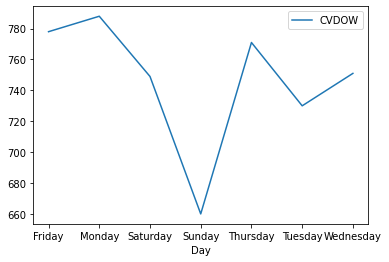

In [13]:
calls["Day"] = calls["CVDOW"].map(dow)
# equal to: calls.loc[:,"Day"] = calls.loc[:,"CVDOW"].map(dow)
calls[["Day","CVDOW"]].groupby('Day').count().plot()

### Cleaning Block Location

块位置包含纬度/经度坐标，我可能想使用这些来分析每个请求的位置。让我们尝试使用正则表达式提取GPS坐标(我们将在以后的课程中讨论正则表达式):

In [14]:
calls['Block_Location'].head(10)

0                           SHATTUCK AVE\nBerkeley, CA
1             FRONTAGE STREET &GILMAN ST\nBerkeley, CA
2    2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...
3                            VIRGINIA ST\nBerkeley, CA
4            UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA
5                              ASHBY AVE\nBerkeley, CA
6                           CATALINA AVE\nBerkeley, CA
7        CALIFORNIA STREET & FAIRVIEW ST\nBerkeley, CA
8                          600 CANYON RD\nBerkeley, CA
9    1700 FOURTH ST\nBerkeley, CA\n(37.871883, -122...
Name: Block_Location, dtype: object

In [15]:
# 字符串处理：split 返回split后的list
s = 'Nina ( North ) Kristen Scott'
s.split("(")[1].split(")")[0]

' North '

In [16]:
def get_lat_lon(s):
    try:
        return s.split("(")[1].split(")")[0]
    except:
        return np.nan

calls_lat_lon = calls['Block_Location'].apply(get_lat_lon) # map 也可以！
calls_lat_lon.head(10)

0                       NaN
1                       NaN
2    37.868574, -122.270415
3                       NaN
4                       NaN
5                       NaN
6                       NaN
7                       NaN
8                       NaN
9    37.871883, -122.301255
Name: Block_Location, dtype: object

In [17]:
# 正则表达式
# pandas method
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t") 
    # Extract Lat and Lon using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*\.\d*)\)", expand=True)
)
calls_lat_lon.head(10)

,Lat,Lon
0,NaN,NaN
1,NaN,NaN
2,37.868574,-122.270415
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,37.871883,-122.301255


#### `~`求反运算
计算数据比例： “~”求反运算 !

In [18]:
# Not all the records have a lat and lon. What fraction do have coordinates?
(~calls_lat_lon.isnull()).mean()

Lat    0.963076
Lon    0.963076
dtype: float64

<br/><br/><br/>


---
## 导入`json`:open(json)
**<font color = darkred>导入为字典。**

Python对JSON数据的支持相对较好，因为它与内部Python对象模型非常匹配。在下面的单元格中，我们将整个JSON数据文件导入到python字典中。

In [19]:
import json

with open("data/stops.json", "rb") as f: # 用 f 代替 open("data/stops.json", "rb")
    stops_json = json.load(f)

`stops_json`变量现在是一个编码文件中的数据的字典:

In [20]:
type(stops_json)

dict

### We can now examine what keys are in the top level json object

We can list the keys to determine what data is stored in the object.

In [21]:
stops_json.keys()

dict_keys(['meta', 'data'])

***
Observation
***
The JSON dictionary contains a `meta` key which likely refers to meta data (data about the data).  Meta data often maintained with the data and can be a good source of additional information.

## Digging into Meta Data

We can investigate the meta data further by examining the keys associated with the metadata.

In [22]:
stops_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to meta-data about a particular "view" of some underlying database.  We will learn more about views as we study SQL later in the class. 

元键**包含另一个名为view的字典**。这可能是指一些底层数据库的特定“视图”的元数据。在后面的课程中，我们将学习更多关于视图的知识。

In [23]:
stops_json['meta']['view'].keys()

dict_keys(['id', 'name', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

注意，这是一个嵌套/递归数据结构。随着我们深入挖掘，我们揭示了越来越多的密钥和相应的数据:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
```

There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [24]:
print(stops_json['meta']['view']['description'])

This data was extracted from the Department’s Public Safety Server and covers data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014). Under that Order, officers were required to provide certain data after making any detention (vehicle, bicycle, pedestrian, suspicious auto).  This dataset provides information about detentions, including the race, sex, age range, of the person detained; the reason for the stop; the type of enforcement taken (if any), and whether or not a search was conducted.  Also provided are the date, time, location of the detention, as well as the incident number and call for service type.


### Columns Meta data

Another potentially useful key in the meta data dictionary is the `columns`.  This returns a list:

元数据字典中另一个可能有用的键是列。返回一个列表:

In [25]:
type(stops_json['meta']['view']['columns'])

list

We can browse summary data in the list using python:

In [37]:
for c in stops_json['meta']['view']['columns']:
    top = ""
    items = ""
    if "cachedContents" in c:
        top = c["cachedContents"]["top"]
        for i in top:
            items = items + "\n\t" + i["item"] + ":" + i["count"]
    print(c["name"], ":", items)

sid : 
id : 
position : 
created_at : 
created_meta : 
updated_at : 
updated_meta : 
meta : 
CreateDatetime : 
	2015-06-11T06:48:26.000:10
	2020-02-13T08:10:43.000:6
	2017-01-26T11:10:06.000:6
	2020-01-07T08:15:40.000:6
	2016-07-03T23:45:04.000:5
	2015-02-01T19:33:13.000:5
	2016-06-11T19:55:36.000:5
	2015-11-16T07:19:28.000:5
	2016-04-19T00:50:19.000:5
	2016-03-25T01:13:14.000:5
	2017-01-06T00:25:16.000:5
	2016-12-22T23:58:59.000:5
	2016-07-19T02:51:56.000:4
	2015-11-09T22:17:36.000:4
	2015-12-19T02:11:34.000:4
	2016-07-21T02:03:22.000:4
	2017-06-29T02:15:29.000:4
	2018-07-02T21:36:29.000:4
	2016-05-25T01:20:06.000:4
	2016-05-01T01:23:53.000:4
IncidentNumber : 
	2020-00001049:6
	2020-00008547:6
	2015-00033565:5
	2016-00039405:5
	2016-00017339:5
	2016-00075241:5
	2016-00034574:5
	2017-00000828:5
	2015-00033576:5
	2015-00067321:5
	2015-00006347:5
	2016-00022806:5
	2016-00030608:4
	2019-00025759:4
	2016-00049625:4
	2018-00010987:4
	2015-00033137:4
	2017-00045853:4
	2016-00042412:4
	2017-0


### Observations?

1. The above meta data tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic. 
1. The old version of this data included descriptions which would be useful in loading and working with the data.
1. JSON makes it easier (than CSV) to create "self-documented data". 
1. Self documenting data can be helpful since it maintains it's own description and these descriptions are more likely to be updated as data changes. 


### Examining the Data Field

We can look at a few entires in the data field


In [38]:
for i in range(3):
    print(i, "\t", stops_json['data'][i])

0 	 ['row-2j6s.qe6z_jtkn', '00000000-0000-0000-D599-E1C6017B6966', 0, 1589533219, None, 1589533219, None, '{ }', '2017-05-02T20:50:29', '2017-00024695', '1275 WALNUT ST', 'BERKELEY', '37.88452086', '-122.268652364', '1194', 'White', 'Female', '30-39', 'Investigation', 'Warning', 'No Search']
1 	 ['row-79rz~ucps-35r6', '00000000-0000-0000-B83C-7A2ADDC55727', 0, 1598605226, None, 1598605226, None, '{ }', '2018-02-20T18:42:04', '2018-00010451', '2176 KITTREDGE ST', 'BERKELEY', '37.868233788', '-122.266394615', '1194', 'White', 'Male', '>40', 'Investigation', 'Other', 'No Search']
2 	 ['row-tmr9_n9ye.6bzh', '00000000-0000-0000-3120-DC62279E5799', 0, 1598605226, None, 1598605226, None, '{ }', '2020-03-04T16:18:11', '2020-00012764', '1414 UNIVERSITY AVE', 'BERKELEY', '37.869690714', '-122.283865643', 'T', 'Black', 'Female', '>40', 'Traffic', 'Citation', 'No Search']


## Building a Dataframe from JSON

In the following block of code we:
1. Translate the JSON records into a dataframe
1. Remove columns that have no metadata description.  This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.
1. Examine the top of the table

In [39]:
# Load the data from JSON and assign column titles
stops = pd.DataFrame(
    stops_json['data'],
    columns=[c['name'] for c in stops_json['meta']['view']['columns']])

stops.head()

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,CreateDatetime,IncidentNumber,...,City,Lat,Lon,CallType,Race,Gender,Age,Reason,Enforcement,Car Search
0,row-2j6s.qe6z_jtkn,00000000-0000-0000-D599-E1C6017B6966,0,1589533219,None,1589533219,None,{ },2017-05-02T20:50:29,2017-00024695,...,BERKELEY,37.88452086,-122.268652364,1194,White,Female,30-39,Investigation,Warning,No Search
1,row-79rz~ucps-35r6,00000000-0000-0000-B83C-7A2ADDC55727,0,1598605226,None,1598605226,None,{ },2018-02-20T18:42:04,2018-00010451,...,BERKELEY,37.868233788,-122.266394615,1194,White,Male,>40,Investigation,Other,No Search
2,row-tmr9_n9ye.6bzh,00000000-0000-0000-3120-DC62279E5799,0,1598605226,None,1598605226,None,{ },2020-03-04T16:18:11,2020-00012764,...,BERKELEY,37.869690714,-122.283865643,T,Black,Female,>40,Traffic,Citation,No Search
3,row-cjve_43yp_s8ec,00000000-0000-0000-4EEF-F940D151C603,0,1598605226,None,1598605226,None,{ },2018-12-04T15:11:14,2018-00067166,...,BERKELEY,37.867138358,-122.268229602,1196,Hispanic,Male,30-39,Traffic,Warning,No Search
4,row-wxqp_6mgh-v4r5,00000000-0000-0000-8B94-7D86EB47C51D,0,1589533219,None,1589533219,None,{ },2020-05-13T09:37:53,2020-00023435,...,BERKELEY,37.865779797,-122.267576002,1194,Black,Male,>40,Traffic,Citation,No Search


In [29]:
stops.columns

Index(['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at',
       'updated_meta', 'meta', 'CreateDatetime', 'IncidentNumber', 'Address',
       'City', 'Lat', 'Lon', 'CallType', 'Race', 'Gender', 'Age', 'Reason',
       'Enforcement', 'Car Search'],
      dtype='object')

## Preliminary Observations

What do we observe so far?

We observe:
1. The `Incident Number` appears to have the year encoded in it - we could potentially use this as a validation check.  
1. The `created_at` and `updated_at` Fields look like they are in milliseconds since January 1, 1970.
1. The `CreateDatetime` Field looks to be formatted in YYYY-MM-DDTHH:MM:SS.  I am guessing T means "Time".
1. The `Age` Field has variable size brackets: 18-29, 30-39, >40.

# Exploration

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

In [30]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,1,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,0,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,3,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,0,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,6,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday


### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [40]:
print("There are", calls['CASENO'].unique().shape[0], "unique case numbers.")
print("There are", calls.shape[0], "calls in the table.")

There are 5227 unique case numbers.
There are 5227 calls in the table.


### Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [32]:
dow = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
calls.groupby('Day')['CASENO'].count()[dow]

Day
Sunday       660
Monday       788
Tuesday      730
Wednesday    751
Thursday     771
Friday       778
Saturday     749
Name: CASENO, dtype: int64

### Examining the Event

We also have data about the different kinds of crimes being reported

In [41]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19092769,THEFT MISD. (UNDER $950),12/09/2019 12:00:00 AM,13:00,LARCENY,1,09/10/2020 07:00:11 AM,"SHATTUCK AVE\nBerkeley, CA",SHATTUCK AVE,Berkeley,CA,Monday
1,19045891,NARCOTICS,08/18/2019 12:00:00 AM,17:20,DRUG VIOLATION,0,09/10/2020 07:00:08 AM,"FRONTAGE STREET &GILMAN ST\nBerkeley, CA",FRONTAGE STREET &GILMAN ST,Berkeley,CA,Sunday
2,19060215,ASSAULT/BATTERY MISD.,10/23/2019 12:00:00 AM,10:45,ASSAULT,3,09/10/2020 07:00:10 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA,Wednesday
3,19092681,VANDALISM,12/01/2019 12:00:00 AM,18:40,VANDALISM,0,09/10/2020 07:00:11 AM,"VIRGINIA ST\nBerkeley, CA",VIRGINIA ST,Berkeley,CA,Sunday
4,19044228,ASSAULT/BATTERY MISD.,08/10/2019 12:00:00 AM,22:51,ASSAULT,6,09/10/2020 07:00:08 AM,"UNIVERSITY AVENUE &FRONTAGE\nBerkeley, CA",UNIVERSITY AVENUE &FRONTAGE,Berkeley,CA,Saturday


### The Offense Field

The Offense field appears to contain the specific crime being reported.  As nominal data we might want to see a summary constructed by computing counts of each offense type:

<AxesSubplot:>

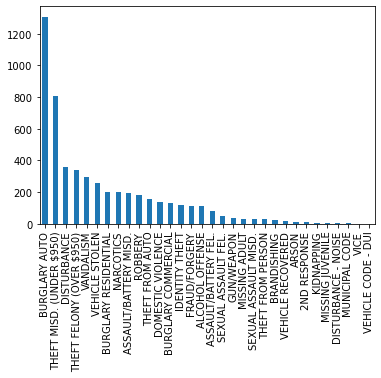

In [42]:
calls['OFFENSE'].value_counts().plot(kind = 'bar')

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

### CVLEGEND

The CVLEGEND field provides the broad category of crime and is a good mechanism to group potentially similar crimes. 

<AxesSubplot:>

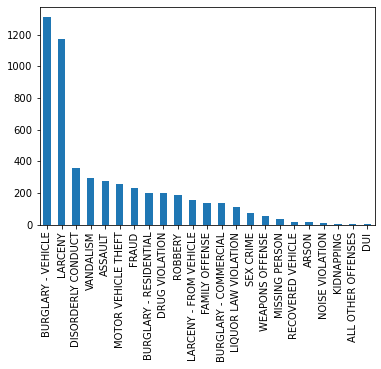

In [35]:
calls['CVLEGEND'].value_counts().plot(kind="bar")

## Advanced: Examine data geographically

In [36]:
import folium
import folium.plugins # The Folium Javascript Map Library

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls_lat_lon[['Lat', 'Lon']].astype('float').dropna().to_numpy()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

ModuleNotFoundError: No module named 'folium'